Dropdown(description='Product:', options=('Shoes', 'Hoodies and Pullovers', 'Jackets & Vests', 'Pants and Tigh…

Dropdown(description='Platform:', options=('Instagram', 'TikTok', 'Facebook'), value='Instagram')

IntSlider(value=1, description='Cluster:', max=2)

Output()

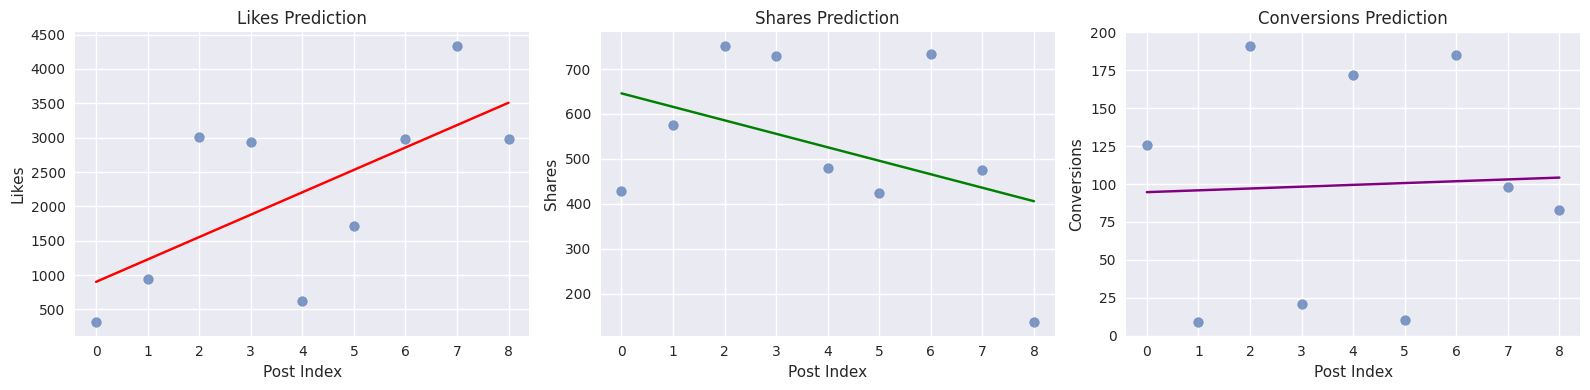

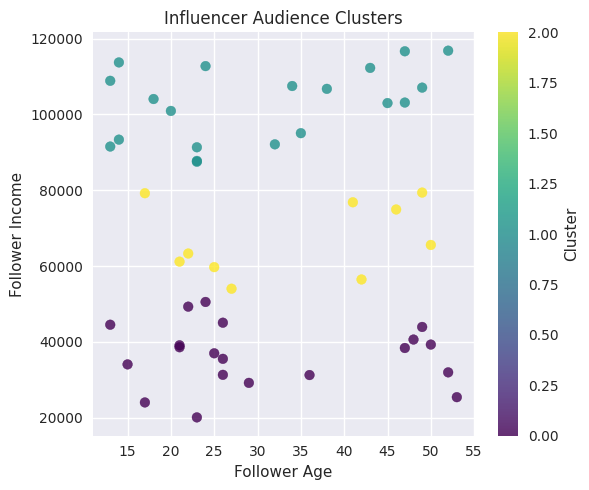

In [8]:
# Cell 1 =========================================================
# Programming Exercise 5-2: Predictive Engagement Lab
# Social Media Manager
# =========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
import ipywidgets as widgets
from IPython.display import display, clear_output
import os
from datetime import datetime

# Make plots a bit cleaner
plt.style.use("seaborn-v0_8")
np.random.seed(42)

# -----------------------------
# 1. Generate Synthetic Data
# -----------------------------
products = [
    "Shoes",
    "Hoodies and Pullovers",
    "Jackets & Vests",
    "Pants and Tights",
    "Tops and T-Shirts",
    "Jerseys",
    "Shorts"
]

platforms = ["Instagram", "TikTok", "Facebook"]

data = pd.DataFrame({
    "product": np.random.choice(products, 200),
    "platform": np.random.choice(platforms, 200),
    "likes": np.random.randint(200, 5000, 200),
    "shares": np.random.randint(20, 800, 200),
    "conversions": np.random.randint(5, 200, 200)
})

# Influencer audience features
influencers = pd.DataFrame({
    "follower_age": np.random.randint(13, 55, 50),
    "follower_income": np.random.randint(20000, 120000, 50),
    "follower_activity": np.random.randint(1, 10, 50)
})

cluster_labels = {
    0: "Budget Audience (Low income, low activity)",
    1: "Mid-Tier Audience (Moderate income, moderate activity)",
    2: "High-Income Audience (High income, high activity)"
}

# -----------------------------
# 2. Create Interactive Widgets
# -----------------------------
product_dropdown = widgets.Dropdown(
    options=products,
    value="Shoes",
    description="Product:"
)

platform_dropdown = widgets.Dropdown(
    options=platforms,
    value="Instagram",
    description="Platform:"
)

cluster_slider = widgets.IntSlider(
    value=1,
    min=0,
    max=2,
    step=1,
    description="Cluster:"
)

output_area = widgets.Output()

# -----------------------------
# 3. Prediction + Visualization
# -----------------------------
def predict(product, platform, cluster):
    """
    Uses the selected product, platform, and cluster to:
    - Filter historical data
    - Fit 3 regression models (likes, shares, conversions)
    - Predict engagement for the next post
    - Compute engagement sentiment + decision
    - Display plots and summary
    """

    clear_output(wait=True)
    display(product_dropdown, platform_dropdown, cluster_slider, output_area)

    filtered = data[(data["product"] == product) & (data["platform"] == platform)]

    if len(filtered) < 2:
        with output_area:
            output_area.clear_output()
            print("Not enough data for this product/platform combination. Please choose another.")
        return

    # Use index as a simple time/progression feature
    X = np.arange(len(filtered)).reshape(-1, 1)
    y_likes = filtered["likes"].values
    y_shares = filtered["shares"].values
    y_conv = filtered["conversions"].values

    model_likes = LinearRegression().fit(X, y_likes)
    model_shares = LinearRegression().fit(X, y_shares)
    model_conv = LinearRegression().fit(X, y_conv)

    next_post = np.array([[len(filtered) + 1]])
    pred_likes = model_likes.predict(next_post)[0]
    pred_shares = model_shares.predict(next_post)[0]
    pred_conv = model_conv.predict(next_post)[0]

    # Store predictions globally so they’re available later if desired
    global CURRENT_PRED_LIKES, CURRENT_PRED_SHARES, CURRENT_PRED_CONV, CURRENT_CLUSTER
    CURRENT_PRED_LIKES = pred_likes
    CURRENT_PRED_SHARES = pred_shares
    CURRENT_PRED_CONV = pred_conv
    CURRENT_CLUSTER = cluster

    # 3-panel regression plots
    fig, axs = plt.subplots(1, 3, figsize=(16, 4))

    # Likes
    axs[0].scatter(X, y_likes, alpha=0.7)
    axs[0].plot(X, model_likes.predict(X), color="red")
    axs[0].set_title("Likes Prediction")
    axs[0].set_xlabel("Post Index")
    axs[0].set_ylabel("Likes")

    # Shares
    axs[1].scatter(X, y_shares, alpha=0.7)
    axs[1].plot(X, model_shares.predict(X), color="green")
    axs[1].set_title("Shares Prediction")
    axs[1].set_xlabel("Post Index")
    axs[1].set_ylabel("Shares")

    # Conversions
    axs[2].scatter(X, y_conv, alpha=0.7)
    axs[2].plot(X, model_conv.predict(X), color="purple")
    axs[2].set_title("Conversions Prediction")
    axs[2].set_xlabel("Post Index")
    axs[2].set_ylabel("Conversions")

    plt.tight_layout()
    plt.show()

    # Clustering visualization
    kmeans = KMeans(n_clusters=3, random_state=42, n_init="auto")
    influencers["cluster"] = kmeans.fit_predict(influencers[["follower_age", "follower_income", "follower_activity"]])

    plt.figure(figsize=(6, 5))
    scatter = plt.scatter(
        influencers["follower_age"],
        influencers["follower_income"],
        c=influencers["cluster"],
        cmap="viridis",
        alpha=0.8
    )
    plt.title("Influencer Audience Clusters")
    plt.xlabel("Follower Age")
    plt.ylabel("Follower Income")
    plt.colorbar(scatter, label="Cluster")
    plt.tight_layout()
    plt.show()

    # Engagement score and sentiment
    engagement_score = (pred_likes * 0.6) + (pred_shares * 0.3) + (pred_conv * 0.1)

    if engagement_score > 3000:
        sentiment = "Strong Positive"
        decision = "YES — Post this content. High engagement expected."
    elif engagement_score > 1500:
        sentiment = "Moderate Positive"
        decision = "Yes — Good engagement likely."
    elif engagement_score > 800:
        sentiment = "Neutral"
        decision = "Maybe — Engagement is uncertain."
    else:
        sentiment = "Negative"
        decision = "No — Engagement too low. Do not post."

    # Store sentiment and decision for later reuse if needed
    global CURRENT_SENTIMENT, CURRENT_DECISION, CURRENT_PRODUCT, CURRENT_PLATFORM
    CURRENT_SENTIMENT = sentiment
    CURRENT_DECISION = decision
    CURRENT_PRODUCT = product
    CURRENT_PLATFORM = platform

    with output_area:
        output_area.clear_output()
        print("Nike Engagement Prediction")
        print("---------------------------")
        print(f"Product: {product}")
        print(f"Platform: {platform}")
        print(f"Influencer Cluster: {cluster} → {cluster_labels[cluster]}")
        print()
        print(f"Predicted Likes: {pred_likes:.0f}")
        print(f"Predicted Shares: {pred_shares:.0f}")
        print(f"Predicted Conversions: {pred_conv:.0f}")
        print()
        print(f"Engagement Sentiment: {sentiment}")
        print(f"Model Decision: {decision}")

# Link widgets to the prediction function
widgets.interactive_output(
    predict,
    {
        "product": product_dropdown,
        "platform": platform_dropdown,
        "cluster": cluster_slider
    }
)

display(product_dropdown, platform_dropdown, cluster_slider, output_area)

# Run once with default selections
predict("Shoes", "Instagram", 1)

In [9]:
# Cell 2 =========================================================
# STUDENT RESPONSE SECTION — SAVES ANSWERS TO CSV
# =========================================================

import pandas as pd
from datetime import datetime
import os

print("\n\n### Programming Exercise 5-2: Student Response Section ###")
print("Please answer the following questions based on the predictions shown in your dashboard.\n")
print("Do NOT change any code in this cell. Only type where you see 'Answer:'.\n")

# Ask for student name (used for file naming and snapshot)
student_name = input("Enter your full name: ").strip()
student_name_safe = student_name.replace(" ", "_")

# 1. Predicted Likes
likes_answer = input("\n1. What is the predicted number of likes for your selected product and platform? \nAnswer: ")

# 2. Predicted Shares
shares_answer = input("\n2. What is the predicted number of shares for your selected product and platform? \nAnswer: ")

# 3. Predicted Conversions
conversions_answer = input("\n3. What is the predicted number of conversions for your selected product and platform? \nAnswer: ")

# 4. Engagement Sentiment
sentiment_answer = input("\n4. What engagement sentiment did the model generate? (Strong Positive, Moderate Positive, Neutral, Negative) \nAnswer: ")

# 5. Posting Decision
decision_answer = input("\n5. According to the model’s decision message, should Nike post this content? (Yes / No / Maybe) \nAnswer: ")

# 6. Cluster Selection
cluster_answer = input("\n6. Which influencer cluster did you choose, and what audience type does it represent? \nAnswer: ")

# 7. Most Influential Metric
metric_answer = input("\n7. Which metric contributed the MOST to the engagement score (likes, shares, or conversions)? \nAnswer: ")

# ---------------------------------------------------------
# SAVE RESPONSES TO A STUDENT-SPECIFIC CSV FILE
# ---------------------------------------------------------

timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

response_data = {
    "timestamp": [timestamp],
    "student_name": [student_name],
    "product_selected": [CURRENT_PRODUCT if "CURRENT_PRODUCT" in globals() else ""],
    "platform_selected": [CURRENT_PLATFORM if "CURRENT_PLATFORM" in globals() else ""],
    "cluster_selected": [CURRENT_CLUSTER if "CURRENT_CLUSTER" in globals() else ""],
    "predicted_likes": [likes_answer],
    "predicted_shares": [shares_answer],
    "predicted_conversions": [conversions_answer],
    "engagement_sentiment": [sentiment_answer],
    "posting_decision": [decision_answer],
    "cluster_choice": [cluster_answer],
    "most_influential_metric": [metric_answer]
}

df_responses = pd.DataFrame(response_data)

# Create folder if it doesn't exist
if not os.path.exists("student_submissions"):
    os.makedirs("student_submissions")

# Save file with student name
file_path = f"student_submissions/{student_name_safe}_exercise_5_2.csv"

# Append if file exists (multiple attempts)
df_responses.to_csv(file_path, mode="a", index=False, header=not os.path.exists(file_path))

print(f"\n✅ Your responses have been saved to: {file_path}")
print("Make sure to also provide a screenshot of your dashboard in your LMS submission.")



### Programming Exercise 5-2: Student Response Section ###
Please answer the following questions based on the predictions shown in your dashboard.

Do NOT change any code in this cell. Only type where you see 'Answer:'.


✅ Your responses have been saved to: student_submissions/Shakia_Riggins_exercise_5_2.csv
Make sure to also provide a screenshot of your dashboard in your LMS submission.



Creating a text snapshot of your answers for your instructor...


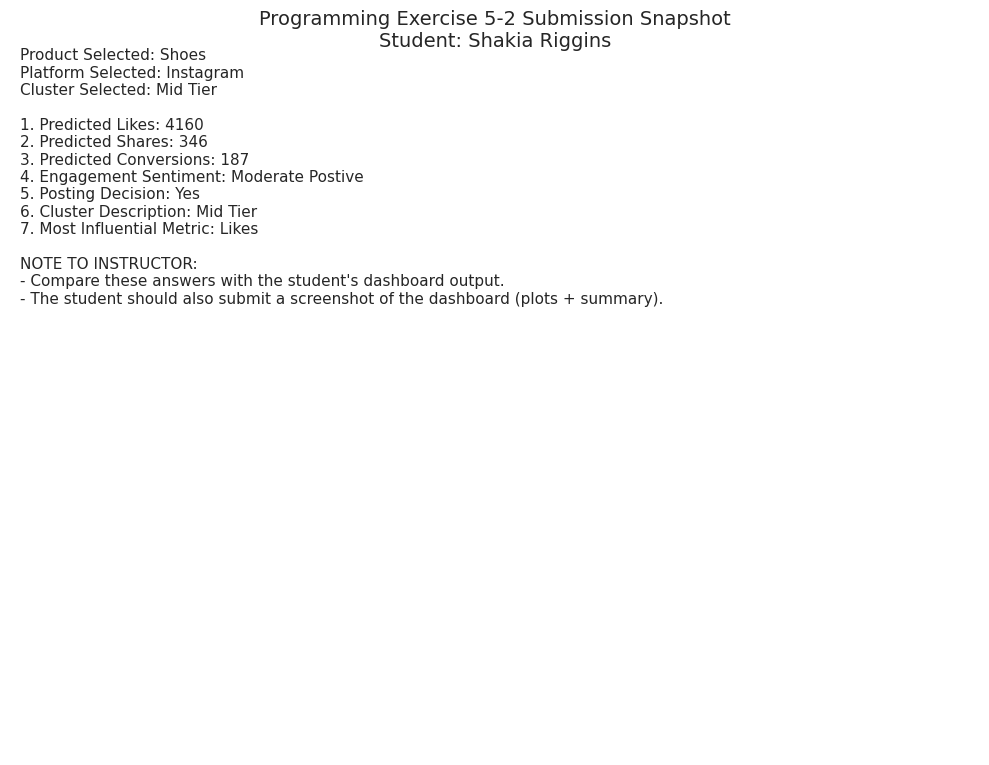


✅ Snapshot image saved to: student_submissions/Shakia_Riggins_snapshot.png
Submit this PNG file and your CSV file in the LMS (Canvas/Blackboard/Moodle/MindTap).


In [10]:
# Cell 3 =========================================================
# SNAPSHOT SUMMARY FOR INSTRUCTOR SUBMISSION
# =========================================================

import matplotlib.pyplot as plt

print("\nCreating a text snapshot of your answers for your instructor...")

fig = plt.figure(figsize=(10, 8))
plt.suptitle(f"Programming Exercise 5-2 Submission Snapshot\nStudent: {student_name}", fontsize=14, y=0.95)

# Text block with all key info
summary_text = (
    f"Product Selected: {CURRENT_PRODUCT if 'CURRENT_PRODUCT' in globals() else 'N/A'}\n"
    f"Platform Selected: {CURRENT_PLATFORM if 'CURRENT_PLATFORM' in globals() else 'N/A'}\n"
    f"Cluster Selected: {cluster_answer}\n\n"
    f"1. Predicted Likes: {likes_answer}\n"
    f"2. Predicted Shares: {shares_answer}\n"
    f"3. Predicted Conversions: {conversions_answer}\n"
    f"4. Engagement Sentiment: {sentiment_answer}\n"
    f"5. Posting Decision: {decision_answer}\n"
    f"6. Cluster Description: {cluster_answer}\n"
    f"7. Most Influential Metric: {metric_answer}\n\n"
    "NOTE TO INSTRUCTOR:\n"
    "- Compare these answers with the student's dashboard output.\n"
    "- The student should also submit a screenshot of the dashboard (plots + summary)."
)

ax = fig.add_subplot(1, 1, 1)
ax.axis("off")
ax.text(0.01, 0.99, summary_text, va="top", fontsize=11)

# Save snapshot next to the CSV
snapshot_path = f"student_submissions/{student_name_safe}_snapshot.png"
plt.tight_layout()
plt.savefig(snapshot_path, dpi=150, bbox_inches="tight")
plt.show()

print(f"\n✅ Snapshot image saved to: {snapshot_path}")
print("Submit this PNG file and your CSV file in the LMS (Canvas/Blackboard/Moodle/MindTap).")